# Molecular cloud mass functions

Color choice: to emphasize link to Chabrier IMF, start from #3D8EDB.  Then use: https://www.w3schools.com/colors/colors_picker.asp to step around in HSV

In [1]:
from __future__ import division

import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table

%matplotlib inline

/usr/local/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated since IPython 4.0.You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


## Rice+ 2016, Sec 4.4 / Table 5

The "r\_" prefixes are ugly, but useful to allow quick comparison against Miville-Deschenes data.

Sec 2.4.1: Rice+ using H2 masses from XCO, no correction for He and metals.

In [2]:
r_mass = np.logspace(4,7,num=100)
r_cdf_outer = (r_mass/1.53e6)**(-2.17+1)  # Outer II+III power law
r_cdf_inner = 11.19 * ((r_mass/1.02e7)**(-1.59+1) - 1)  # Inner I+IV truncated power law
r_cdf_all = (r_mass/5.12e7)**(-1.89+1)  # All clouds
r_cdf_all_trunc = 8.54 * ((r_mass/1.05e7)**(-1.72+1) - 1)  # All clouds

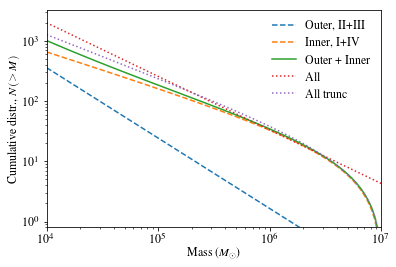

In [3]:
plt.loglog(r_mass, r_cdf_outer, '--', label='Outer, II+III')
plt.loglog(r_mass, r_cdf_inner, '--', label='Inner, I+IV')
plt.loglog(r_mass, r_cdf_outer + r_cdf_inner, label='Outer + Inner')
plt.loglog(r_mass, r_cdf_all, ':', label='All')
plt.loglog(r_mass, r_cdf_all_trunc, ':', label='All trunc')

plt.legend(loc='best', frameon=False)
plt.xlim(1e4, 1e7)
plt.ylim(ymin=0.8)
plt.xlabel(r'Mass ($M_{\odot}$)')
plt.ylabel(r'Cumulative distr., $N(>M)$')
plt.show()

Assume that mass sampled is not significantly affected by catalog filters (vLSR > 20 km/s, >20 deg. from l=0 and l=180).  The differential spectrum is just a power law:

$$
    \frac{\mathrm{d}N}{\mathrm{d}M} = - \frac{N_0}{M_0} (\gamma+1) \left(\frac{M}{M_0}\right)^\gamma
$$

In [4]:
r_mw_mass = 2.45e8  # Msun, estimated H2 mass of total catalog of 1039 clouds.
rho_H2 = 1.9e7  # Msun / Mpc^3 from Obreschkow & Rawlings 2009, based on FCRAO survey

# Use numbers from "r_cdf_all_trunc" fit
N0 = 8.54
M0 = 1.05e7
gamma = -1.72
r_df = -1 * N0/M0 * (gamma+1) * (r_mass/M0)**gamma
r_dN_dMdV = r_df * rho_H2 / r_mw_mass

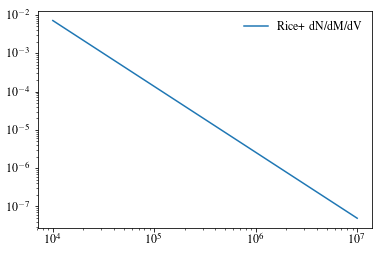

In [5]:
plt.loglog(r_mass, r_dN_dMdV, label='Rice+ dN/dM/dV')
plt.legend(frameon=False)
plt.show()

In [6]:
footerText='/GMCs (MW,dendr)/#3ddb8c/--/'
np.savetxt('mcloudsMWdendr.txt', np.array([r_mass, r_dN_dMdV]).T,
           fmt='%1.3e \t',header='M (M_s) \t dN/dMdV (M_s^-1 pc^-3)',footer=footerText)

## Miville-Deschenes

Table doesn't parse well, so finagle Table read arguments.  See API at...
http://docs.astropy.org/en/stable/api/astropy.table.Table.html#astropy.table.Table.read

Section 3.1.3: they apply factor $\mu = 1.36$ to account for He and metals, yielding estimates of total MC mass.
I remove this factor to just show H2 mass.

In [7]:
#cols = ['Cloud', 'Ncomp', 'Npix', 'A', 'l', 'e_l', 'b', 'e_b', 'theta', 'WCO',
#        'NH2', 'Sigma', 'vcent', 'sigmav', 'Rmax', 'Rmin', 'Rang', 'Rgal',
#        'INF', 'Dn', 'Df', 'zn', 'zf', 'Sn', 'Sf', 'Rn', 'Rf', 'Mn', 'Mf']
#units=['', '', '', 'deg2', 'deg', 'deg', 'deg', 'deg', 'deg',
#       '', 'cm-2', 'solMass/pc2', 'km/s', 'km/s', 'deg', 'deg', 'deg', 'deg',
#       '', 'kpc', 'kpc', 'kpc', 'kpc', 'pc2', 'pc2', 'pc', 'pc', 'solMass', 'solMass']

md = Table.read('mclouds/apjaa4dfdt1_mrt.txt', format='ascii', data_start=45,
                names=['Cloud', 'Ncomp', 'Npix', 'A', 'l', 'e_l', 'b', 'e_b', 'theta',
                       'WCO', 'NH2', 'Sigma', 'vcent', 'sigmav', 'Rmax', 'Rmin', 'Rang', 'Rgal',
                       'INF', 'Dn', 'Df', 'zn', 'zf', 'Sn', 'Sf', 'Rn', 'Rf', 'Mn', 'Mf'])

Extract correct cloud mass based on favored kinematic distance

In [8]:
md_masses = []
for row in md:
    if row['INF'] == 0:  # near kinematic distance
        md_masses.append(row['Mn'])
    elif row['INF'] == 1:  # far kinematic distance
        md_masses.append(row['Mf'])
    else:
        raise Exception("Invalid INF value")

md_masses.sort()
md_masses = np.array(md_masses) / 1.36  # Convert total MC mass to H2 mass

md_cdf = np.arange(len(md_masses)-1, -1, -1)  # 8106,8105,...,0 for #clouds > current mass

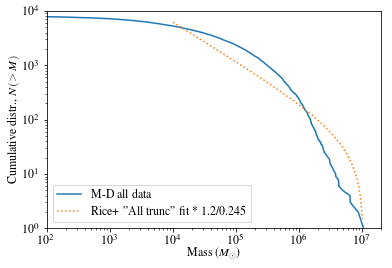

In [9]:
plt.loglog(md_masses, md_cdf, label='M-D all data')
plt.plot(r_mass, r_cdf_all_trunc*1.2/0.245, ':', label='Rice+ "All trunc" fit * 1.2/0.245')
plt.xlim(1e2, 2e7)
plt.ylim(1e0, 1e4)
plt.xlabel(r'Mass ($M_{\odot}$)')
plt.ylabel(r'Cumulative distr., $N(>M)$')
plt.legend()
plt.show()

Use pyplot histogram to generate dN/dM

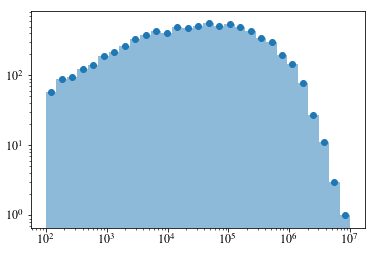

In [10]:
md_hist = plt.hist(md_masses, bins=np.logspace(2,7,30), alpha=0.5)
plt.xscale('log')
plt.yscale('log')

num = md_hist[0]
edges = md_hist[1]
dlog10m = np.mean(np.log10(edges[1:]) - np.log10(edges[:-1]))
ctrs = 10**( dlog10m/2 + np.log10(edges[:-1]) )

plt.scatter(ctrs, num)
plt.show()

To get dN/d(logM), normalize the logarithmic histogram values as:
$$
    \frac{\mathrm{d}N}{\mathrm{d}\log M} = \frac{\mathtt{hist}}{\Delta (\log M)}
$$

Then convert to dN/dM as:
$$
    \frac{\mathrm{d}N}{\mathrm{d} M} = \frac{\mathrm{d}N}{\mathrm{d}\log M} \frac{1}{\ln 10} \frac{1}{M}
$$

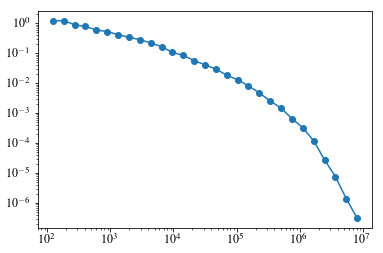

In [11]:
# NOTE np.logspace is base 10, np.log is base e
dN_dM = num / dlog10m / np.log(10) / ctrs
plt.plot(ctrs, dN_dM, 'o-')
plt.xscale('log')
plt.yscale('log')
plt.show()

Finally rescale to dN/dM/dV

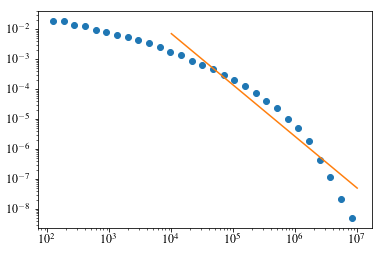

In [12]:
md_mw_mass = 1.2e9  # Msun, estimated H2 mass (not MC mass!) of total catalog
rho_H2 = 1.9e7  # Msun / Mpc^3 from Obreschkow & Rawlings 2009, based on FCRAO survey

md_dN_dMdV = dN_dM * rho_H2 / md_mw_mass

plt.loglog(ctrs, md_dN_dMdV, 'o')
plt.loglog(r_mass, r_dN_dMdV)
plt.show()

Apply completeness filter: within 10 kpc, all clouds >10^4 Msun should be detected by Miville-Deschenes+.
There are certainly smaller clouds not being detected.  Calculation using their eq (40) is:

    3.5*1e6*5*(4.76e-6) * 10^2 = 8330

which matches their Fig. 24.

In [13]:
footerText='/GMCs (MW,gauss)/#30e8e8/-/'
np.savetxt('mcloudsMWgauss.txt', np.array([ctrs[ctrs>1e4], md_dN_dMdV[ctrs>1e4]]).T,
           fmt='%1.3e \t',header='M (M_s) \t dN/dMdV (M_s^-1 pc^-3)',footer=footerText)

UNUSED BRANCH: I tried spline interpolation to estimate the derivative $dN/dM$, but that proved unnecessary.
However, it's a useful check that I did the histogram binning correctly.

In [14]:
from scipy import interpolate

In [15]:
md_cdf_spline = interpolate.UnivariateSpline(md_masses, md_cdf)
md_df_spline = md_cdf_spline.derivative()

Show that the smoothed spline describes the data well, and does not contain extra noise

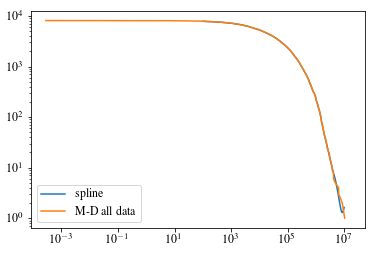

In [16]:
md_mass_samp = np.logspace(2,7,10000)
plt.loglog(md_mass_samp, md_cdf_spline(md_mass_samp), label='spline')
plt.loglog(md_masses, md_cdf, label='M-D all data')
plt.legend()
plt.show()

The spline derivative is very noisy.  Probably easily fixed with a smoothing parameter, but no need.

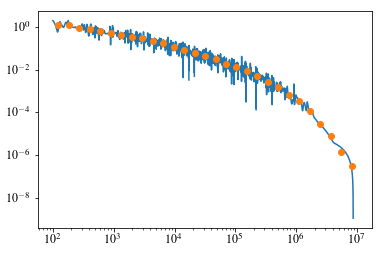

In [17]:
plt.loglog(md_mass_samp, -1 * md_df_spline(md_mass_samp), label='spline')
plt.plot(ctrs, dN_dM, 'o')
plt.show()